In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from hindemith import hmarray
from hindemith.core import compose
from hindemith.operations.array import Square
from hindemith.operations.convolve import Convolve2D
import hindemith as hm
import cv2
from hmcaffe.demo.classify import classify
from box import get_boxes
import numpy as np

def show_bgr_im(frame):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()

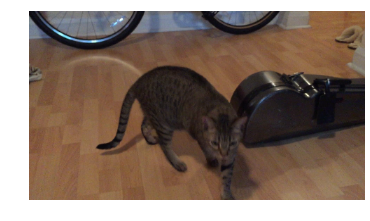

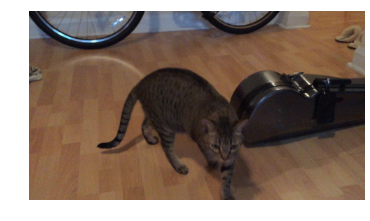

In [2]:
frame0 = cv2.resize(cv2.imread('images/output-0099.png'), (480, 270))
frame1 = cv2.resize(cv2.imread('images/output-0100.png'), (480, 270))

show_bgr_im(frame0)
show_bgr_im(frame1)

In [3]:
alpha = 15

jacobi = np.array([
    [1.0/12.0, 1.0/6.0, 1.0/12.0],
    [1.0/6.0, 0.0, 1.0/6.0],
    [1.0/12.0, 1.0/6.0, 1.0/12.0]
])

dx = np.array([[-1.0/12.0, -2.0/3.0, 0.0, 2.0/3.0, 1.0/12.0]])
dy = np.array([[-1.0/12.0], [-2.0/3.0], [0.0], [2.0/3.0], [1.0/12.0]])

alpha2 = alpha ** 2
epsilon = .01

@compose
def hs_jacobi(im0, im1, u, v):
    It = im1 - im0
    Iy = Convolve2D(im1, dy)
    Ix = Convolve2D(im1, dx)
    denom = Square(Ix) + Square(Iy) + alpha2

    for _ in range(100):
        ubar = Convolve2D(u, jacobi)
        vbar = Convolve2D(v, jacobi)
        t = (Ix * ubar + Iy * vbar + It) / denom
        u_new = ubar - Ix * t
        v_new = vbar - Iy * t
        u, v = u_new, v_new
    return u, v


([<hindemith.core.Source object at 0x13374ee90>, <hindemith.core.Source object at 0x133739650>], [<hindemith.core.Sink object at 0x133741e90>])
([<hindemith.core.Source object at 0x133758390>, <hindemith.core.Source object at 0x133758150>], [<hindemith.core.Sink object at 0x133123a10>])
([<hindemith.core.Source object at 0x1337580d0>, <hindemith.core.Source object at 0x133758090>], [<hindemith.core.Sink object at 0x1337583d0>])
([<hindemith.core.Source object at 0x133758410>], [<hindemith.core.Sink object at 0x133758110>])
([<hindemith.core.Source object at 0x133758490>], [<hindemith.core.Sink object at 0x133758050>])
([<hindemith.core.Source object at 0x133758510>, <hindemith.core.Source object at 0x133758550>], [<hindemith.core.Sink object at 0x133758450>])
([<hindemith.core.Source object at 0x1337585d0>, <hindemith.core.Source object at 0x133758610>], [<hindemith.core.Sink object at 0x1337584d0>])
['Iy', 'im0', 'Ix', 'denom', 'im1', 'It']

    __kernel void fn(global float* Iy, glob

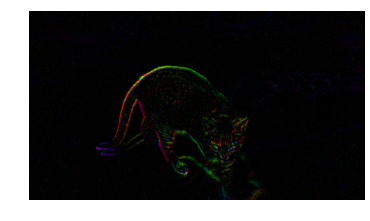

In [4]:
hsv = np.zeros_like(frame0)
im0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY).astype(np.float32).view(hmarray)
hm_u = hm.zeros_like(im0)
hm_v = hm.zeros_like(im0)
im1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY).astype(np.float32).view(hmarray)

hm_u, hm_v = hs_jacobi(im0, im1, hm_u, hm_v)

hm_u.sync_host()
hm_v.sync_host()
mag, ang = cv2.cartToPolar(hm_u, hm_v)
mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
ang = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 0] = ang
hsv[..., 2] = mag
flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
show_bgr_im(flow)

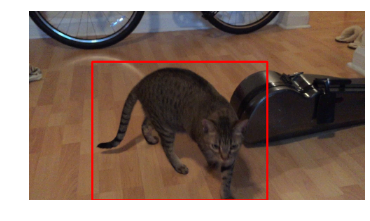

In [5]:
windows = get_boxes(mag, frame1)
show_bgr_im(frame1)

([<hindemith.core.Source object at 0x13ddf0190>], [<hindemith.core.Sink object at 0x13ddf0950>])
([<hindemith.core.Source object at 0x13de68d10>], [<hindemith.core.Sink object at 0x13de68c90>, <hindemith.core.Sink object at 0x13de68cd0>])
([<hindemith.core.Source object at 0x133741310>], [<hindemith.core.Sink object at 0x13de68b90>])
([<hindemith.core.Source object at 0x133739d50>], [<hindemith.core.Sink object at 0x133739c50>, <hindemith.core.Sink object at 0x133739cd0>])
([<hindemith.core.Source object at 0x133739e90>], [<hindemith.core.Sink object at 0x133739d90>])
([<hindemith.core.Source object at 0x13dde08d0>], [<hindemith.core.Sink object at 0x133739ed0>])
([<hindemith.core.Source object at 0x13dde0dd0>], [<hindemith.core.Sink object at 0x13dde0910>])
([<hindemith.core.Source object at 0x13de86a90>], [<hindemith.core.Sink object at 0x13dde0d10>, <hindemith.core.Sink object at 0x13de86bd0>])
([<hindemith.core.Source object at 0x13de86fd0>], [<hindemith.core.Sink object at 0x13de8

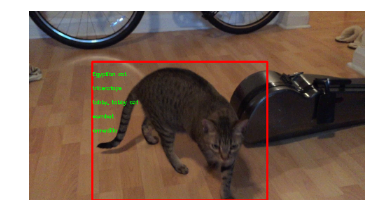

In [6]:
labeled = np.copy(frame1)
for window in windows:
    labels = classify(frame1[window[0]:window[2],
                             window[1]:window[3]])
    print("---------")
    for i, label in enumerate(reversed(labels)):
        label = label.split(" ")
        cv2.putText(labeled, " ".join(label[1:]), (window[1], window[0] + (i + 1) * 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, .25, (0, 255, 0), 1)
        print(label)

show_bgr_im(labeled)